In [40]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import random

In [41]:
data = pd.read_csv('diabetes.csv')
# Nowy plik, bo KNN mocno mieli, więc wolę testować osobno puszczając cały plik

In [42]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [43]:
# Klasa statyczna zawierająca metody przydatne to przetwarzania danych
class ProcessingData:

    # metoda tasująca wiersze pd.DataFrame
    @staticmethod
    def shuffle(df: pd.DataFrame) -> pd.DataFrame:
        """
        Receives a DataFrame, randomly shuffles it and returns a shuffled version.
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        for idx in range(len(df) - 1, 0, -1):
            rand_idx = random.randint(0, idx)
            df.iloc[idx], df.iloc[rand_idx] = df.iloc[rand_idx], df.iloc[idx]
        return df

    # metoda normalizująca kolumny pd.DataFrame za pomocą normalizacji z użyciem odchylenia standardowego
    @staticmethod
    def normalize_std(df: pd.DataFrame, label: str) -> pd.DataFrame:
        """
        Receives a DataFrame and a class label to skip during normalization, normalizes data using min-max normalization and returns the normalized version.
        :param label: str
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        normalized = df.drop(labels=label, axis=1)
        normalized = (normalized-normalized.mean())/(normalized.std())
        return normalized.join(df[label])

    # metoda normalizująca kolumny pd.DataFrame za pomocą normalizacji minmax
    @staticmethod
    def normalize_minmax(df: pd.DataFrame, label: str) -> pd.DataFrame:
        """
        Receives a DataFrame and a class label to skip during normalization, normalizes data using min-max normalization and returns the normalized version.
        :param label: str
        :param df: pd.DataFrame
        :return df: pd.DataFrame
        """
        normalized = df.drop(labels=label, axis=1)
        normalized = (normalized-normalized.min())/(normalized.max()-normalized.min())
        return normalized.join(df[label])

    # metoda dzieląca pd.DataFrame na zbiór treningowy oraz walidacyjny
    @staticmethod
    def split(df: pd.DataFrame, ratio: float) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Receives a DataFrame and returns two dataframes, split into training and validation DataFrames.
        :param df: pd.DataFrame
        :param ratio: float
        :return training_df, validation_df: tuple[pd.DataFrame, pd.DataFrame]
        """
        cutoff = int(len(df) * ratio)
        return df[:cutoff].reset_index(drop=True), df[cutoff:].reset_index(drop=True)

In [44]:
shuffled_data = ProcessingData.shuffle(data)
training_data, validation_data = ProcessingData.split(shuffled_data, 0.7)

In [45]:
# Klasyfikator zbiorów rozmytych
"""
Normy:
Pregnancies:
-
Glucose:
- 70-99 prawidlowe
- 100-125 ryzyko
- 126+ cukrzyca
BloodPressure:
- <80 prawidlowe
- 80-89 podwyzszone faza 1
- >90 podwyszone faza 2
SkinThickness:
- mediana 25 mm
Insulin:
- <30
Age:
- ryzyko od 45 r.ż.
BMI:
- 18.5 - 24.9 waga prawidłowa
- 25.0 - 29.9 nadwaga
- >30 otyłość
DiabetesPedigreeFunction
-
"""

'\nNormy:\nPregnancies:\n-\nGlucose:\n- 70-99 prawidlowe\n- 100-125 ryzyko\n- 126+ cukrzyca\nBloodPressure:\n- <80 prawidlowe\n- 80-89 podwyzszone faza 1\n- >90 podwyszone faza 2\nSkinThickness:\n- mediana 25 mm\nInsulin:\n- <30\nAge:\n- ryzyko od 45 r.ż.\nBMI:\n- 18.5 - 24.9 waga prawidłowa\n- 25.0 - 29.9 nadwaga\n- >30 otyłość\nDiabetesPedigreeFunction\n-\n'

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64

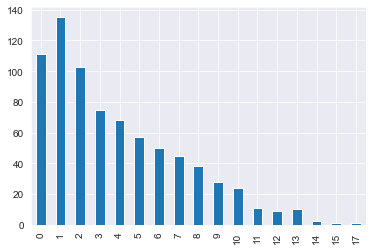

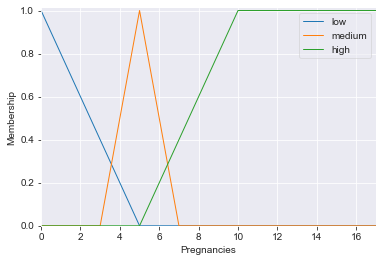

In [46]:
pregnancies_data = data['Pregnancies']
pregnancies_data.value_counts().sort_index().plot.bar(sort_columns=True)
pregnancies = ctrl.Antecedent(pregnancies_data.sort_values(), 'Pregnancies')
pregnancies['low'] = fuzz.trimf(pregnancies.universe, [0, 0, 5])
pregnancies['medium'] = fuzz.trimf(pregnancies.universe, [3, 5, 7])
pregnancies['high'] = fuzz.trapmf(pregnancies.universe, [5, 10, 17, 17])
pregnancies.view()
pregnancies_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    763.000000
mean     121.686763
std       30.535641
min       44.000000
25%       99.000000
50%      117.000000
75%      141.000000
max      199.000000
Name: Glucose, dtype: float64

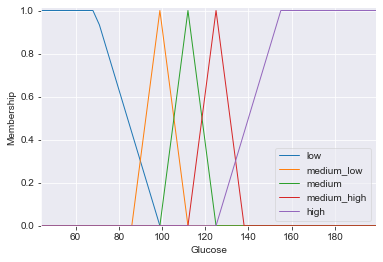

In [47]:
glucose_data = data['Glucose']
glucose_data = glucose_data[glucose_data != 0]
glucose = ctrl.Antecedent(glucose_data.sort_values(), 'Glucose')
glucose['low'] = fuzz.trapmf(glucose.universe, [44, 44, 69, 99])
glucose['medium_low'] = fuzz.trimf(glucose.universe, [86, 99, 112])
glucose['medium'] = fuzz.trimf(glucose.universe, [99, 112, 125])
glucose['medium_high'] = fuzz.trimf(glucose.universe, [112, 125, 138])
glucose['high'] = fuzz.trapmf(glucose.universe, [125, 155, 199, 199])
glucose.view()
glucose_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    733.000000
mean      72.405184
std       12.382158
min       24.000000
25%       64.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

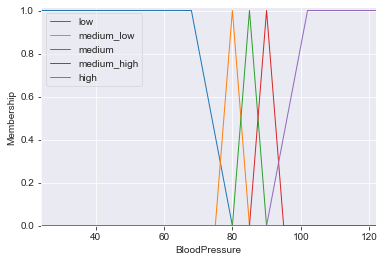

In [48]:
bloodpressure_data = data['BloodPressure']
bloodpressure_data = bloodpressure_data[bloodpressure_data != 0]
bloodpressure = ctrl.Antecedent(bloodpressure_data.sort_values(), 'BloodPressure')
bloodpressure['low'] = fuzz.trapmf(bloodpressure.universe, [24, 24, 68, 80])
bloodpressure['medium_low'] = fuzz.trimf(bloodpressure.universe, [75, 80, 85])
bloodpressure['medium'] = fuzz.trimf(bloodpressure.universe, [80, 85, 90])
bloodpressure['medium_high'] = fuzz.trimf(bloodpressure.universe, [85, 90, 95])
bloodpressure['high'] = fuzz.trapmf(bloodpressure.universe, [90, 102, 122, 122])
bloodpressure.view()
bloodpressure_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    541.000000
mean      29.153420
std       10.476982
min        7.000000
25%       22.000000
50%       29.000000
75%       36.000000
max       99.000000
Name: SkinThickness, dtype: float64

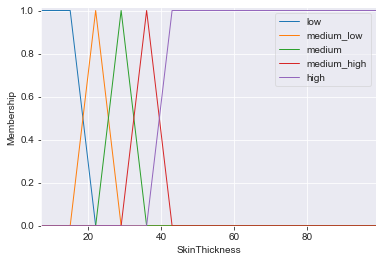

In [49]:
skinthickness_data = data['SkinThickness']
skinthickness_data = skinthickness_data[skinthickness_data != 0]
skinthickness = ctrl.Antecedent(skinthickness_data.sort_values(), 'SkinThickness')
skinthickness['low'] = fuzz.trapmf(skinthickness.universe, [7, 7, 15, 22])
skinthickness['medium_low'] = fuzz.trimf(skinthickness.universe, [15, 22, 29])
skinthickness['medium'] = fuzz.trimf(skinthickness.universe, [22, 29, 36])
skinthickness['medium_high'] = fuzz.trimf(skinthickness.universe, [29, 36, 43])
skinthickness['high'] = fuzz.trapmf(skinthickness.universe, [36, 43, 99, 99])
skinthickness.view()
skinthickness_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    394.000000
mean     155.548223
std      118.775855
min       14.000000
25%       76.250000
50%      125.000000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

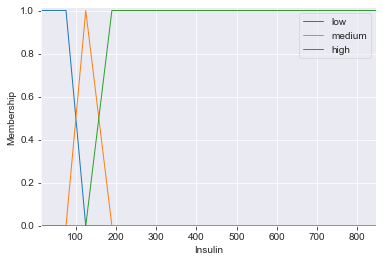

In [50]:
insulin_data = data['Insulin']
insulin_data = insulin_data[insulin_data != 0]
insulin = ctrl.Antecedent(insulin_data.sort_values(), 'Insulin')
insulin['low'] = fuzz.trapmf(insulin.universe, [14, 14, 76, 125])
insulin['medium'] = fuzz.trimf(insulin.universe, [76, 125, 190])
insulin['high'] = fuzz.trapmf(insulin.universe, [125, 190, 846, 846])
insulin.view()
insulin_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    757.000000
mean      32.457464
std        6.924988
min       18.200000
25%       27.500000
50%       32.300000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

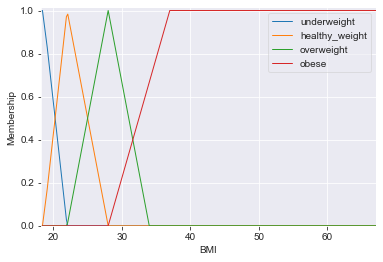

In [316]:
bmi_data = data['BMI']
bmi_data = bmi_data[bmi_data != 0]
bmi = ctrl.Antecedent(bmi_data.sort_values(), 'BMI')
bmi['underweight'] = fuzz.trapmf(bmi.universe, [18.2, 18.2, 18.5, 22])
bmi['healthy_weight'] = fuzz.trimf(bmi.universe, [18.5, 22, 28])
bmi['overweight'] = fuzz.trimf(bmi.universe, [22, 28, 34])
bmi['obese'] = fuzz.trapmf(bmi.universe, [28, 37, 67.1, 67.1])
bmi.view()
bmi_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

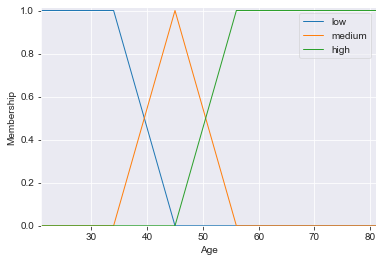

In [52]:
age_data = data['Age']
age_data = age_data[age_data != 0]
age = ctrl.Antecedent(age_data.sort_values(), 'Age')
age['low'] = fuzz.trapmf(age.universe, [21, 21, 34, 45])
age['medium'] = fuzz.trimf(age.universe, [34, 45, 56])
age['high'] = fuzz.trapmf(age.universe, [45, 56, 81, 81])
age.view()
age_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

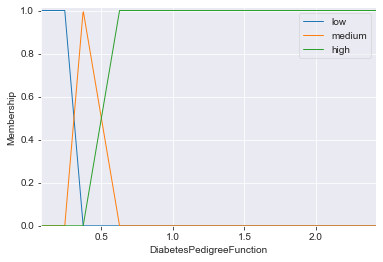

In [53]:
diabetespedigreefunction_data = data['DiabetesPedigreeFunction']
diabetespedigreefunction_data = diabetespedigreefunction_data[diabetespedigreefunction_data != 0]
diabetespedigreefunction = ctrl.Antecedent(diabetespedigreefunction_data.sort_values(), 'DiabetesPedigreeFunction')
diabetespedigreefunction['low'] = fuzz.trapmf(diabetespedigreefunction.universe, [0.078, 0.078, 0.24375, 0.3725])
diabetespedigreefunction['medium'] = fuzz.trimf(diabetespedigreefunction.universe, [0.24375, 0.3725, 0.62625])
diabetespedigreefunction['high'] = fuzz.trapmf(diabetespedigreefunction.universe, [0.3725, 0.626250, 2.42, 2.42])
diabetespedigreefunction.view()
diabetespedigreefunction_data.describe()

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


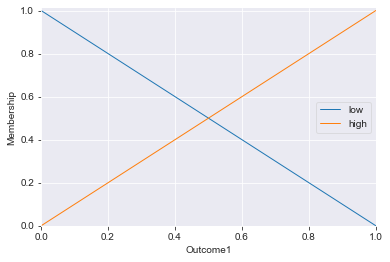

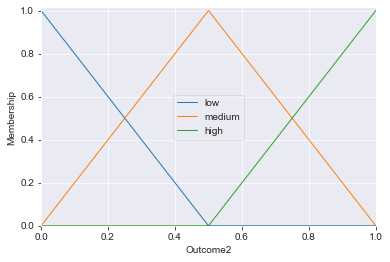

In [389]:
outcome1 = ctrl.Consequent(np.linspace(0., 1., num=101), 'Outcome1')
outcome1['low'] = fuzz.trimf(outcome1.universe, [0, 0, 1])
outcome1['high'] = fuzz.trimf(outcome1.universe, [0, 1, 1])
# outcome1.automf(2, names=['low', 'high'])
outcome1.view()

outcome2 = ctrl.Consequent(np.linspace(0., 1., num=101), 'Outcome2')
outcome2['low'] = fuzz.trimf(outcome2.universe, [0, 0, 0.5])
outcome2['medium'] = fuzz.trimf(outcome2.universe, [0, 0.5, 1])
outcome2['high'] = fuzz.trimf(outcome2.universe, [0.5, 1, 1])
# outcome2.automf(3)
outcome2.view()

In [419]:
# Zasady dla Outcome bez przypadków połowicznych
rule101 = ctrl.Rule(glucose['low'] & bloodpressure['low'] & insulin['low'], outcome1['low'])
rule102 = ctrl.Rule(glucose['low'] & bloodpressure['low'] & bmi['underweight'], outcome1['low'])
rule103 = ctrl.Rule(glucose['low'] & insulin['low'] & bmi['underweight'], outcome1['low'])
rule104 = ctrl.Rule(bloodpressure['low'] & insulin['low'] & bmi['underweight'], outcome1['low'])

rule120 = ctrl.Rule(pregnancies['low'] & age['low'] & skinthickness['low'], outcome1['low'])
rule121 = ctrl.Rule(pregnancies['low'] & age['low'] & diabetespedigreefunction['low'], outcome1['low'])
rule122 = ctrl.Rule(pregnancies['low'] & skinthickness['low'] & diabetespedigreefunction['low'], outcome1['low'])
rule123 = ctrl.Rule(age['low'] & skinthickness['low'] & diabetespedigreefunction['low'], outcome1['low'])


# rule131 = ctrl.Rule(glucose['high'] & bloodpressure['high'], outcome1['high'])
# rule132 = ctrl.Rule(glucose['high'] & insulin['high'], outcome1['high'])
# rule133 = ctrl.Rule(glucose['high'] & bmi['overweight'], outcome1['high'])
# rule134 = ctrl.Rule(glucose['high'] & bmi['obese'], outcome1['high'])
# rule135 = ctrl.Rule(bloodpressure['high'] & insulin['high'], outcome1['high'])
# rule136 = ctrl.Rule(bloodpressure['high'] & bmi['overweight'], outcome1['high'])
# rule137 = ctrl.Rule(bloodpressure['high'] & bmi['obese'], outcome1['high'])
# rule138 = ctrl.Rule(insulin['high'] & bmi['overweight'], outcome1['high'])
# rule139 = ctrl.Rule(insulin['high'] & bmi['obese'], outcome1['high'])

rule131 = ctrl.Rule(glucose['high'] & bloodpressure['high'] & insulin['high'], outcome1['high'])
rule132 = ctrl.Rule(glucose['high'] & bloodpressure['high'] & bmi['overweight'], outcome1['high'])
rule133 = ctrl.Rule(glucose['high'] & bloodpressure['high'] & bmi['obese'], outcome1['high'])
rule134 = ctrl.Rule(glucose['high'] & insulin['high'] & bmi['overweight'], outcome1['high'])
rule135 = ctrl.Rule(glucose['high'] & insulin['high'] & bmi['obese'], outcome1['high'])
rule136 = ctrl.Rule(bloodpressure['high'] & insulin['high'] & bmi['overweight'], outcome1['high'])
rule137 = ctrl.Rule(bloodpressure['high'] & insulin['high'] & bmi['obese'], outcome1['high'])
rule138 = ctrl.Rule(glucose['high'] & bloodpressure['medium_high'] & insulin['high'], outcome1['high'])
rule139 = ctrl.Rule(glucose['high'] & bloodpressure['medium_high'] & bmi['overweight'], outcome1['high'])
rule140 = ctrl.Rule(glucose['high'] & bloodpressure['medium_high'] & bmi['obese'], outcome1['high'])
rule141 = ctrl.Rule(bloodpressure['medium_high'] & insulin['high'] & bmi['overweight'], outcome1['high'])
rule142 = ctrl.Rule(bloodpressure['medium_high'] & insulin['high'] & bmi['obese'], outcome1['high'])

rule150 = ctrl.Rule(pregnancies['medium'] & age['high'] & skinthickness['high'], outcome1['high'])
rule151 = ctrl.Rule(pregnancies['medium'] & age['high'] & diabetespedigreefunction['high'], outcome1['high'])
rule152 = ctrl.Rule(pregnancies['medium'] & skinthickness['high'] & diabetespedigreefunction['high'], outcome1['high'])
rule153 = ctrl.Rule(age['high'] & skinthickness['high'] & diabetespedigreefunction['high'], outcome1['high'])

rule154 = ctrl.Rule(pregnancies['high'] & age['high'] & skinthickness['high'], outcome1['high'])
rule155 = ctrl.Rule(pregnancies['high'] & age['high'] & diabetespedigreefunction['high'], outcome1['high'])
rule156 = ctrl.Rule(pregnancies['high'] & skinthickness['high'] & diabetespedigreefunction['high'], outcome1['high'])

In [420]:
outcome1_ctrl = ctrl.ControlSystem([rule101, rule102, rule103, rule104,
                                    rule120, rule121, rule122, rule123,
                                    rule131, rule132, rule133, rule134,
                                    rule135, rule136, rule137, rule138,
                                    rule139, rule140, rule141, rule142,
                                    rule150, rule151, rule152, rule153,
                                    rule154, rule155, rule156])
outcome1_test = ctrl.ControlSystemSimulation(outcome1_ctrl)

In [431]:
sample = data.iloc[random.randint(0, 768)]
# sample = data[data['Pregnancies'] == 17]
outcome1_test.input['Pregnancies'] = sample['Pregnancies']
outcome1_test.input['Glucose'] = sample['Glucose']
outcome1_test.input['BloodPressure'] = sample['BloodPressure']
outcome1_test.input['SkinThickness'] = sample['SkinThickness']
outcome1_test.input['Insulin'] = sample['Insulin']
outcome1_test.input['BMI'] = sample['BMI']
outcome1_test.input['DiabetesPedigreeFunction'] = sample['DiabetesPedigreeFunction']
outcome1_test.input['Age'] = sample['Age']
outcome1_test.compute()
print(round(outcome1_test.output['Outcome1'], 3), sample['Outcome'])

0.535 0.0


In [426]:
from statistics import mean


zeros = []
ones = []
for _, sample in data[data['Outcome'] == 0].iterrows():
    outcome1_test.input['Pregnancies'] = sample['Pregnancies']
    outcome1_test.input['Glucose'] = sample['Glucose']
    outcome1_test.input['BloodPressure'] = sample['BloodPressure']
    outcome1_test.input['SkinThickness'] = sample['SkinThickness']
    outcome1_test.input['Insulin'] = sample['Insulin']
    outcome1_test.input['BMI'] = sample['BMI']
    outcome1_test.input['DiabetesPedigreeFunction'] = sample['DiabetesPedigreeFunction']
    outcome1_test.input['Age'] = sample['Age']
    outcome1_test.compute()
    zeros.append(outcome1_test.output['Outcome1'])
print(round(mean(zeros), 3))

for _, sample in data[data['Outcome'] == 1].iterrows():
    outcome1_test.input['Pregnancies'] = sample['Pregnancies']
    outcome1_test.input['Glucose'] = sample['Glucose']
    outcome1_test.input['BloodPressure'] = sample['BloodPressure']
    outcome1_test.input['SkinThickness'] = sample['SkinThickness']
    outcome1_test.input['Insulin'] = sample['Insulin']
    outcome1_test.input['BMI'] = sample['BMI']
    outcome1_test.input['DiabetesPedigreeFunction'] = sample['DiabetesPedigreeFunction']
    outcome1_test.input['Age'] = sample['Age']
    outcome1_test.compute()
    ones.append(outcome1_test.output['Outcome1'])
print(round(mean(ones), 3))

ValueError: Crisp output cannot be calculated, likely because the system is too sparse. Check to make sure this set of input values will activate at least one connected Term in each Antecedent via the current set of Rules.

C:\Users\detym\OneDrive - Moe, Inc\Desktop\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


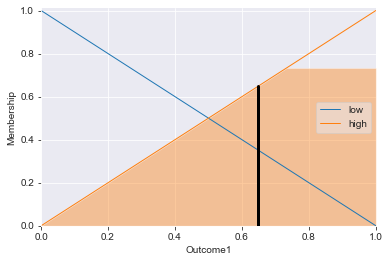

In [197]:
outcome1.view(sim=outcome1_test)